In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg
from scipy import ndimage

# modify to where you store your project data including utils.py
# datadir = "/content/drive/My Drive/cs445_projects/proj3/" 
datadir = "./" 

utilfn = datadir + "utils.py"

samplesfn = datadir + "samples"
# !cp -r "$samplesfn" .
import utils

In [2]:
def eye_detection(img):
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.equalizeHist(image_gray)
    #-- Detect faces
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
    faces = face_cascade.detectMultiScale(image_gray, 1.3, 5)
    plt.imshow(img)
    print(faces)
    eyes_total = []
    for (x,y,w,h) in faces:
        center = (x + w//2, y + h//2)
        img = cv2.ellipse(img, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
        faceROI = image_gray[y:y+h,x:x+w]
        start = 5
        eyes = np.array(eye_cascade.detectMultiScale(faceROI, 1.1, 5))
        while eyes.shape[0] > 2:
            start +=5
            eyes = eye_cascade.detectMultiScale(faceROI, 1.03, start)
        print(eyes.shape)
        x1,y1,w1,h1 = eyes[0]
        x2,y2,w2,h2 = eyes[1]   
        eye1_center = (x + x1 + w1//2, y + y1 + h1//2)
        radius1 = int(round((w1 + h1)*0.25))
        img = cv2.circle(img, eye1_center, radius1, (255, 0, 0 ), 4)
        eye2_center = (x + x2 + w2//2, y + y2 + h2//2)
        radius2 = int(round((w2 + h2)*0.25))
        img = cv2.circle(img, eye2_center, radius2, (255, 0, 0 ), 4)
        eyes_total.append(np.array([[x + x1 + w1//2, y + y1 + h1//2], [x + x2 + w2//2, y + y2 + h2//2]]))
        
        plt.figure()
        result = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('double') / 255.0 
        plt.imshow(result)
#     cv2.imshow('Capture - Face detection', img)
#     eyes = np.array([[x + x1 + w1//2, y + y1 + h1//2], [x + x2 + w2//2, y + y2 + h2//2]])
    return np.array(eyes_total)

def compute_mask(eye_raw):
    eye = eye_raw.copy()
    if eye_raw[0][0] > eye_raw[1][0]:
        eye[0] = eye_raw[1]
        eye[1] = eye_raw[0]
        
    dis_x = eye[1][0] - eye[0][0]
    dis_y = eye[1][1] - eye[0][1]
    p1 = [eye[0][0] - 0.3*dis_x + 0.3*dis_y, eye[0][1] - 0.3*dis_x - 0.3*dis_y]
    p2 = [eye[1][0] + 0.3*dis_x + 0.3*dis_y, eye[0][1] - 0.3*dis_x + 0.3*dis_y]
    
    p3 = [eye[1][0] + 0.1*dis_x - 1.3*dis_y, eye[1][1] + 1.3*dis_x + 0.1*dis_y]
    p4 = [eye[0][0] - 0.1*dis_x - 1.3*dis_y, eye[0][1] + 1.3*dis_x - 0.1*dis_y]
    x_list = (p1[0], p2[0], p3[0], p4[0])
    y_list = (p1[1], p2[1], p3[1], p4[1])
    x_extra = (p1[0]+1, p2[0]-1, p3[0]-1, p4[0]+1)
    y_extra = (p1[1]-1, p2[1]-1, p3[1]+1, p4[1]+1)
    return x_list, y_list, x_extra, y_extra

# This function will always keeps the tar image unchanged.
# it will rotate and scale src to match with tar.
def align_images_plus(src, tar, eye_s, eye_t):
    # Compute the scale difference between src and tar image.
    x_s = eye_s[0][0] - eye_s[1][0]
    y_s = eye_s[0][1] - eye_s[1][1]
    
    x_t = eye_t[0][0] - eye_t[1][0]
    y_t = eye_t[0][1] - eye_t[1][1]
    
    dis_s = np.sqrt((x_s)**2 + (y_s)**2)
    dis_t = np.sqrt((x_t)**2 + (y_t)**2)
    scale = dis_t / dis_s
    
    angle_s = np.arctan(y_s/x_s)
    angle_t = np.arctan(y_t/x_t)
    print("angle_s: ", angle_s*180, " angle_t: ", angle_t*180)
#     angle_s - angle_t
    #rotation angle in degree
    result = ndimage.rotate(src, (angle_s - angle_t) * 180 / np.pi , reshape = False)

    width = int(result.shape[1] * scale)
    height = int(result.shape[0] * scale)
    
    resized = cv2.resize(result, (width, height), interpolation = cv2.INTER_AREA)
#     plt.figure()
#     plt.imshow(resized)
    return resized


def catch_face(pic, eye1_r, eye2_r):
    eye1 = eye1_r.copy()
    if eye1_r[0][0] > eye1_r[1][0]:
        eye1[0] = eye1_r[1]
        eye1[1] = eye1_r[0]
        
    dis_x = eye1[1][0] - eye1[0][0]
    dis_y = eye1[1][1] - eye1[0][1]
    p1 = [eye1[0][0] - int(1.3*dis_x) + 2*dis_y, eye1[0][1] - int(1.3*dis_x) - 2*dis_y]
    p2 = [eye1[1][0] + int(1.3*dis_x) + 2*dis_y, eye1[0][1] - int(1.3*dis_x) + 2*dis_y]
    p3 = [eye1[1][0] + 2*dis_x - 2*dis_y, eye1[1][1] + 2*dis_x + 2*dis_y]
    p4 = [eye1[0][0] - 2*dis_x - 2*dis_y, eye1[0][1] + 2*dis_x - 2*dis_y]
    
    
    face1 = pic[p1[1]:p4[1],p1[0]:p2[0]].copy()
    print(p1[0]," : ", p2[0], " ",  p1[1]," : ",p4[1])
    
    eye2 = eye2_r.copy()
    if eye2_r[0][0] > eye2_r[1][0]:
        eye2[0] = eye2_r[1]
        eye2[1] = eye2_r[0]
    
    dis_x = eye2[1][0] - eye2[0][0]
    dis_y = eye2[1][1] - eye2[0][1]
    p1 = [eye2[0][0] - int(1.3*dis_x) + 2*dis_y, eye2[0][1] - int(1.3*dis_x) - 2*dis_y]
    p2 = [eye2[1][0] + int(1.3*dis_x) + 2*dis_y, eye2[0][1] - int(1.3*dis_x) + 2*dis_y]
    p3 = [eye2[1][0] + 2*dis_x - 2*dis_y, eye2[1][1] + 2*dis_x + 2*dis_y]
    p4 = [eye2[0][0] - 2*dis_x - 2*dis_y, eye2[0][1] + 2*dis_x - 2*dis_y]
    
    face2 = pic[p1[1]:p4[1], p1[0]:p2[0]].copy()
    print(p1[0]," : ", p2[0], " ",  p1[1]," : ",p4[1])
    
    return face1, face2

In [3]:


# eye_locations = eye_detection(cv2.imread('samples/ff.jpeg'))
# print(eye_locations)

# pic = cv2.cvtColor(cv2.imread('samples/ff.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

# f1, f2 = catch_face(pic, eye_locations[0], eye_locations[1])

# cv2.imwrite("samples/face1.jpeg", f1*255)
# cv2.imwrite("samples/face2.jpeg", f2*255)

# eye_locations = eye_detection(cv2.imread('samples/face1.jpeg'))
# print(eye_locations)
# eye_locations = eye_detection(cv2.imread('samples/face2.jpeg'))
# print(eye_locations)

In [192]:
# plt.figure()
# plt.imshow(f1)

# plt.figure()
# plt.imshow(f2)

# plt.figure()
# plt.imshow(pic)

In [3]:

def blend(object_img, background_img, eye1, eye2):

    xs,ys, xe, ye = compute_mask(eye1)
    object_mask = utils.get_mask(ys, xs, object_img)
    
    xb,yb,_,_ = compute_mask(eye2)

    bottom_center = (int((xb[2]+xb[3])/2), int((yb[2]+yb[3])/2)) # (x,y)
    object_img, object_mask = utils.crop_object_img(object_img, object_mask)
    bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)

    im_blend = np.zeros(background_img.shape)
    # temp = 0
    object_mask[-1,:] *= 0
    object_mask[:,-1] *= 0
    object_mask[0,:]  *= 0
    object_mask[:,0]  *= 0
    for b in np.arange(3):
        im_blend[:,:,b] = utils.poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

    return im_blend

# find the face of the source image, and attach it on target's head.
def blend_face_together(picture_address):
    background_img = cv2.cvtColor(cv2.imread(picture_address), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
    eye_locations = eye_detection(cv2.imread(picture_address))
    
    
    f1, f2 = catch_face(background_img, eye_locations[0], eye_locations[1])
    
    cv2.imwrite("samples/face1.jpeg", f1*255)
    cv2.imwrite("samples/face2.jpeg", f2*255)
    
    eye1_locations = eye_detection(cv2.imread('samples/face1.jpeg'))
    eye2_locations = eye_detection(cv2.imread('samples/face2.jpeg'))
    print(eye1_locations)
    print(eye2_locations)
    face1 = np.float32(cv2.imread('samples/face1.jpeg') / 255.0)
    face2 = np.float32(cv2.imread('samples/face2.jpeg') / 255.0)

    res1 = align_images_plus(face1, background_img, eye1_locations[0], eye_locations[1])
    cv2.imwrite("samples/face1.jpeg", res1*255)
    
    res2 = align_images_plus(face2, background_img, eye2_locations[0], eye_locations[0])
    cv2.imwrite("samples/face2.jpeg", res2*255)
    
    eye1 = eye_detection(cv2.imread('samples/face1.jpeg'))
    eye2 = eye_detection(cv2.imread('samples/face2.jpeg'))

    output1 = blend(res1, background_img, eye1[0], eye_locations[1])
    output2 = blend(res2, output1, eye2[0], eye_locations[0])
    return output2


453  :  910   29  :  448
82  :  667   268  :  805
[[[307 143]
  [180 151]]]
[[[229 193]
  [394 184]]]
angle_s:  -11.323621086322554  angle_t:  -9.928568867072185
angle_s:  -9.808462123331614  angle_t:  -9.911231167260652


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


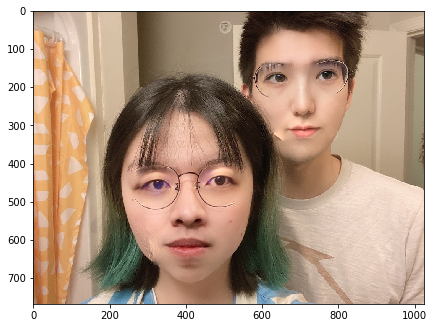

In [5]:
im = blend_face_together('samples/ff.jpeg')

plt.figure(figsize=(7,7))
plt.imshow(im)

In [41]:

# find the face of the source image, and attach it on target's head.
def blend_face(source, target):
    background_img = cv2.cvtColor(cv2.imread(target), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
    object_img = cv2.cvtColor(cv2.imread(source), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

    eye2_locations = eye_detection(cv2.imread(target))
    eye1_locations = eye_detection(cv2.imread(source))
    print(eye2_locations[0])
    print(eye1_locations)
    tar = cv2.cvtColor(np.float32(cv2.imread(target) / 255.0), cv2.COLOR_BGR2RGB) 
    src = cv2.cvtColor(np.float32(cv2.imread(source) / 255.0), cv2.COLOR_BGR2RGB)

    res = align_images_plus(src, tar, eye1_locations, eye2_locations)
    cv2.imwrite("samples/face.jpeg", res*255)
    
    eye1 = eye_detection(cv2.imread('samples/face.jpeg'))
    eye2 = eye2_locations

    object_img = res
    background_img = tar

    xs,ys, xe, ye = compute_mask(eye1)
    object_mask = utils.get_mask(ys, xs, object_img)
    
    xb,yb,_,_ = compute_mask(eye2)

    bottom_center = (int((xb[2]+xb[3])/2), int((yb[2]+yb[3])/2)) # (x,y)
    object_img, object_mask = utils.crop_object_img(object_img, object_mask)
    bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)

    im_blend = np.zeros(background_img.shape)
    # temp = 0
    object_mask[-1,:] *= 0
    object_mask[:,-1] *= 0
    object_mask[0,:]  *= 0
    object_mask[:,0]  *= 0
    for b in np.arange(3):
        im_blend[:,:,b] = utils.poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

    plt.figure(figsize=(7,7))
    plt.imshow(im_blend)
    return im_blend




In [42]:
source = 'samples/55.jpg'
target = 'samples/woman.jpeg'
im_blend_1 = blend_face(source, target)
im_blend_2 = blend_face(target, source)

[[200 124]
 [118 127]]
[[[239 264]
  [366 265]]]


IndexError: index 1 is out of bounds for axis 0 with size 1

In [21]:
source = 'samples/fii.jpeg'
target = 'samples/fi.jpeg'
im_blend_1 = blend_face(source, target)
im_blend_2 = blend_face(target, source)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [20]:
source1 = 'samples/woman-1.jpeg'
target1 = 'samples/woman-2.jpeg'
im_blend_1 = blend_face(source1, target1)
im_blend_2 = blend_face(target1, source1)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
im = blend_face_together('samples/ff.jpeg')

plt.figure(figsize=(7,7))
plt.imshow(im)

[[603 104 255 255]
 [134 244 375 375]]
(2, 4)
(2, 4)
571  :  895   82  :  379
60  :  520   252  :  674
[[ 43  27 236 236]]
(2, 4)
[[ 97  21 331 331]]
(2, 4)
[[[113 120]
  [204 123]]]
[[[190 139]
  [319 125]]]
angle_s:  5.9319175705736615  angle_t:  -18.218779500144
angle_s:  -19.45872634183486  angle_t:  3.999341758809431
[[ 65  43 318 318]]
(2, 4)
[[ 61  16 240 240]]
(2, 4)


KeyboardInterrupt: 

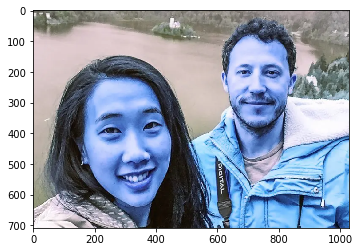

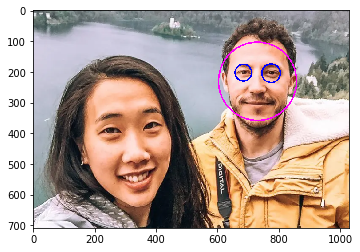

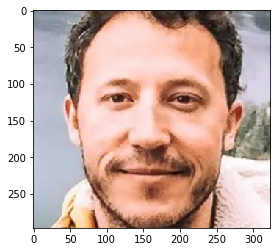

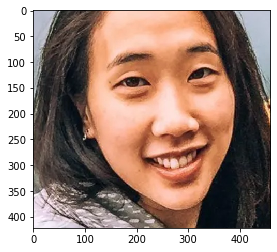

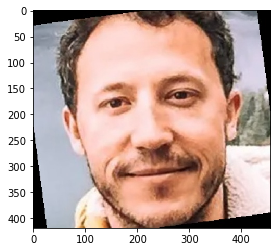

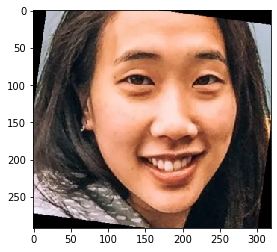

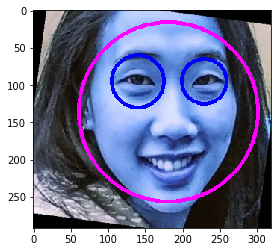

In [4]:
im = blend_face_together('samples/couple_1.jpeg')

plt.figure(figsize=(7,7))
plt.imshow(im)

[[ 138  277  631  631]
 [1305  333  502  502]]
(2, 4)
(2, 4)
58  :  839   243  :  959
1153  :  1909   264  :  957
[[128  74 550 550]]
(2, 4)
[[154  75 495 495]]
(2, 4)
[[[501 278]
  [283 279]]]
[[[280 269]
  [491 264]]]
angle_s:  -0.8256822820915113  angle_t:  -2.571253665731393
angle_s:  -4.264604724676425  angle_t:  -1.6589392030233197
[[105  60 559 559]]
(2, 4)
[[159  85 506 506]]
(2, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


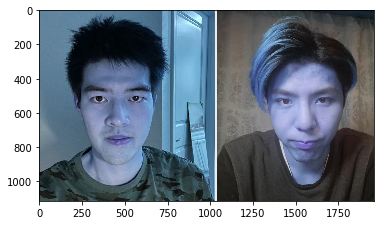

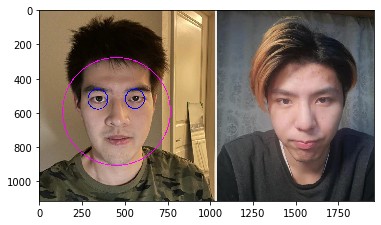

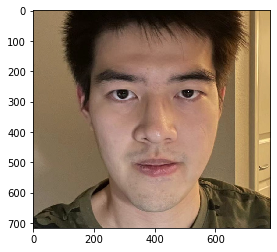

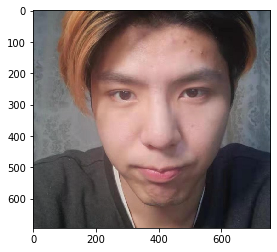

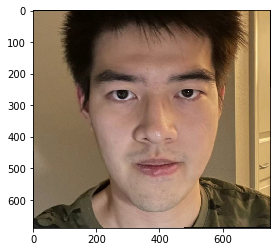

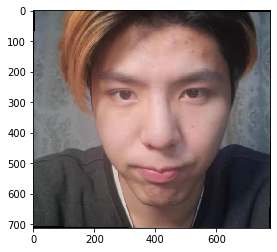

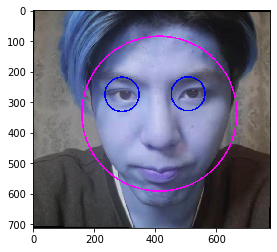

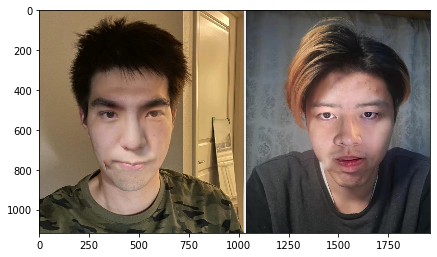

In [5]:
im = blend_face_together('samples/hrzn.jpeg')

plt.figure(figsize=(7,7))
plt.imshow(im)

In [ ]:
https://www.pexels.com/photo/adult-attractive-beautiful-beauty-415829/

[[  87  156  652  652]
 [1277  493  524  524]]


array([[[ 280,  422],
        [ 512,  409]],

       [[1633,  690],
        [1407,  695]]])

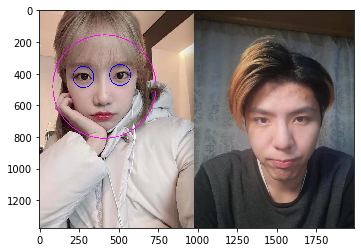

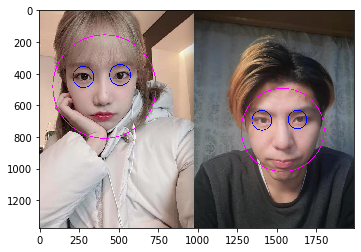

In [147]:
eye_detection(cv2.imread('samples/test_1.jpeg'))

In [151]:
def blr(img):
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #-- Detect faces
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
    faces = face_cascade.detectMultiScale(image_gray, 1.03, 5)
    print(faces)
    eyes_total = []
    for (x,y,w,h) in faces:
        center = (x + w//2, y + h//2)
        img = cv2.ellipse(img, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
        faceROI = image_gray[y:y+h,x:x+w]
        start = 5
        eyes = np.array(eye_cascade.detectMultiScale(faceROI, 1.1, 5))
        while eyes.shape[0] > 2:
            start +=5
            eyes = eye_cascade.detectMultiScale(faceROI, 1.03, start)
        x1,y1,w1,h1 = eyes[0]
        x2,y2,w2,h2 = eyes[1]   
        eye1_center = (x + x1 + w1//2, y + y1 + h1//2)
        radius1 = int(round((w1 + h1)*0.25))
        img = cv2.circle(img, eye1_center, radius1, (255, 0, 0 ), 4)
        eye2_center = (x + x2 + w2//2, y + y2 + h2//2)
        radius2 = int(round((w2 + h2)*0.25))
        img = cv2.circle(img, eye2_center, radius2, (255, 0, 0 ), 4)
        eyes_total.append(np.array([[x + x1 + w1//2, y + y1 + h1//2], [x + x2 + w2//2, y + y2 + h2//2]]))
        
        plt.figure()
        result = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('double') / 255.0 
        plt.imshow(result)
#     cv2.imshow('Capture - Face detection', img)
#     eyes = np.array([[x + x1 + w1//2, y + y1 + h1//2], [x + x2 + w2//2, y + y2 + h2//2]])
    return np.array(eyes_total)

[[139  46 522 522]]


array([[[495, 237],
        [289, 243]]])

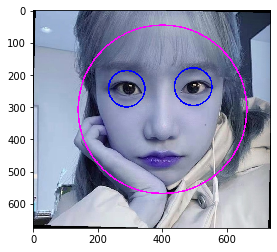

In [152]:
blr(cv2.imread('samples/res1.jpeg'))

In [146]:
def eye_detection(img):
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #-- Detect faces
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
    faces = face_cascade.detectMultiScale(image_gray, 1.3, 5)
    print(faces)
    eyes_total = []
    for (x,y,w,h) in faces:
        center = (x + w//2, y + h//2)
        img = cv2.ellipse(img, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
        faceROI = image_gray[y:y+h,x:x+w]
        start = 5
        eyes = np.array(eye_cascade.detectMultiScale(faceROI, 1.1, 5))
        while eyes.shape[0] > 2:
            start +=5
            eyes = eye_cascade.detectMultiScale(faceROI, 1.03, start)
        x1,y1,w1,h1 = eyes[0]
        x2,y2,w2,h2 = eyes[1]   
        eye1_center = (x + x1 + w1//2, y + y1 + h1//2)
        radius1 = int(round((w1 + h1)*0.25))
        img = cv2.circle(img, eye1_center, radius1, (255, 0, 0 ), 4)
        eye2_center = (x + x2 + w2//2, y + y2 + h2//2)
        radius2 = int(round((w2 + h2)*0.25))
        img = cv2.circle(img, eye2_center, radius2, (255, 0, 0 ), 4)
        eyes_total.append(np.array([[x + x1 + w1//2, y + y1 + h1//2], [x + x2 + w2//2, y + y2 + h2//2]]))
        
        plt.figure()
        result = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('double') / 255.0 
        plt.imshow(result)
#     cv2.imshow('Capture - Face detection', img)
#     eyes = np.array([[x + x1 + w1//2, y + y1 + h1//2], [x + x2 + w2//2, y + y2 + h2//2]])
    return np.array(eyes_total)
def blend_face_together(picture_address):
    background_img = cv2.cvtColor(cv2.imread(picture_address), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
    eye_locations = eye_detection(cv2.imread(picture_address))
    print("eye_locations.shape:",eye_locations.shape)
    
    f1, f2 = catch_face(background_img, eye_locations[0], eye_locations[1])
    
    cv2.imwrite("samples/face1.jpeg", f1*255)
    cv2.imwrite("samples/face2.jpeg", f2*255)
    
    eye1_locations = eye_detection(cv2.imread('samples/face1.jpeg'))
    eye2_locations = eye_detection(cv2.imread('samples/face2.jpeg'))
    print("eye1_locations:", eye1_locations.shape)
    print("eye2_locations:", eye2_locations.shape)
    print("eye_locations:", eye_locations)
    face1 = np.float32(cv2.imread('samples/face1.jpeg') / 255.0)
    face2 = np.float32(cv2.imread('samples/face2.jpeg') / 255.0)
    
    res1 = align_images_plus(face1, background_img, eye1_locations[0], eye_locations[1])
    cv2.imwrite("samples/res1.jpeg", res1*255)
    
    res2 = align_images_plus(face2, background_img, eye2_locations[0], eye_locations[0])
    cv2.imwrite("samples/res2.jpeg", res2*255)
    
    eye1 = blr(cv2.imread('samples/res1.jpeg'))
    eye2 = eye_detection(cv2.imread('samples/res2.jpeg'))

    output1 = blend(res1, background_img, eye1[0], eye_locations[1])
    output2 = blend(res2, output1, eye2[0], eye_locations[0])
    return output2
